<a href="https://colab.research.google.com/github/mridulmahajan04/Text_Similarity_Topsis_Mridul_Mahajan_102396003/blob/main/TopsisPreTrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                  Model  TOPSIS Score  Rank
3  distiluse-base-multilingual-cased-v1      0.985380     3
0                      all-MiniLM-L6-v2      0.920748     4
1                     all-mpnet-base-v2      0.894152     1
2               paraphrase-MiniLM-L6-v2      0.563682     2
4             bert-base-nli-mean-tokens      0.102838     5


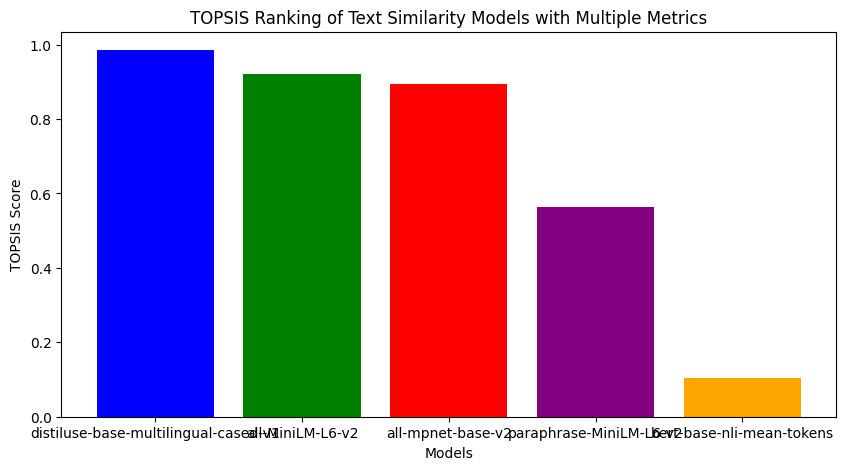

In [3]:
# !pip install datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# Define models to compare
models = [
    "all-MiniLM-L6-v2",
    "all-mpnet-base-v2",
    "paraphrase-MiniLM-L6-v2",
    "distiluse-base-multilingual-cased-v1",
    "bert-base-nli-mean-tokens"
]

# Load an external dataset
dataset = load_dataset("stsb_multi_mt", name="en", split="test")
text_pairs = list(zip(dataset["sentence1"], dataset["sentence2"]))[:200]  # Taking a larger sample

# Compute similarity scores with different metrics
def compute_similarity(model_name, dataset):
    model = SentenceTransformer(model_name)
    cosine_scores, euclidean_scores, manhattan_scores = [], [], []
    for sent1, sent2 in dataset:
        emb1 = model.encode(sent1).reshape(1, -1)
        emb2 = model.encode(sent2).reshape(1, -1)
        cosine_scores.append(cosine_similarity(emb1, emb2)[0][0])
        euclidean_scores.append(-euclidean_distances(emb1, emb2)[0][0])  # Negative for TOPSIS benefit criterion
        manhattan_scores.append(-manhattan_distances(emb1, emb2)[0][0])  # Negative for TOPSIS benefit criterion
    return np.mean(cosine_scores), np.mean(euclidean_scores), np.mean(manhattan_scores)

# Store results
metrics = {}
for model in models:
    cosine_sim, euclidean_sim, manhattan_sim = compute_similarity(model, text_pairs)
    metrics[model] = [cosine_sim * 100, euclidean_sim * 100, manhattan_sim * 100, 0, 0]  # Placeholder for inference time and size

# Convert metrics to numpy array
data = np.array(list(metrics.values()))
criteria = ['Cosine Similarity', 'Euclidean Similarity', 'Manhattan Similarity', 'Inference Time', 'Model Size']
weights = np.array([0.4, 0.3, 0.2, 0.05, 0.05])
benefit_criteria = [1, 1, 1, 0, 0]

# Prevent division by zero by replacing zero columns with a small value
col_sums = np.sqrt((data**2).sum(axis=0))
col_sums[col_sums == 0] = 1e-9  # Small value to avoid division by zero

# Apply TOPSIS
norm_data = data / col_sums
weighted_data = norm_data * weights
ideal_best = np.max(weighted_data, axis=0) * benefit_criteria + np.min(weighted_data, axis=0) * (1 - np.array(benefit_criteria))
ideal_worst = np.min(weighted_data, axis=0) * benefit_criteria + np.max(weighted_data, axis=0) * (1 - np.array(benefit_criteria))

distance_best = np.sqrt(((weighted_data - ideal_best) ** 2).sum(axis=1))
distance_worst = np.sqrt(((weighted_data - ideal_worst) ** 2).sum(axis=1))

topsis_scores = distance_worst / (distance_best + distance_worst)
rankings = np.argsort(topsis_scores)[::-1] + 1

# Display Results
results_df = pd.DataFrame({
    'Model': list(models),
    'TOPSIS Score': topsis_scores,
    'Rank': rankings
}).sort_values(by='TOPSIS Score', ascending=False)

print(results_df)

# Visualization
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['TOPSIS Score'], color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Models")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Text Similarity Models with Multiple Metrics")
plt.show()
